<a href="https://colab.research.google.com/github/chayaphon/DADS7202_DL/blob/main/CNN_Sushi/Xception_Base.ipynb\" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# List all NVIDIA GPUs as avaialble.
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-299b49ee-76ac-3399-1e47-b9f202a90b71)


In [1]:
import sys
import numpy as np
import sklearn
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.9.18 (main, Sep 11 2023, 13:30:38) [MSC v.1916 64 bit (AMD64)]

NumPy 1.26.4

The scikit-learn version is 1.5.1
TensorFlow 2.10.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# Set Seed

In [3]:
seed_value = 123456 #np.random.randint(1000, 99999)
print(seed_value)

tf.random.set_seed(seed_value)
np.random.seed(seed_value)

123456


# Prep Data

In [4]:
x1 = np.load('./Images Numpy/x_sushi_aburi_299x299.npz')
x2 = np.load('./Images Numpy/x_sushi_ebi_299x299.npz')
x3 = np.load('./Images Numpy/x_sushi_maguro_299x299.npz')
x4 = np.load('./Images Numpy/x_sushi_salmon_299x299.npz')

x1 = x1['x']
x2 = x2['x']
x3 = x3['x']
x4 = x4['x']

y1 = np.array([0 for i in range(172)])
y2 = np.array([1 for i in range(172)])
y3 = np.array([2 for i in range(172)])
y4 = np.array([3 for i in range(172)])

print(f'x1 : {x1.shape} | y1: {y1.shape}')
print(f'x2 : {x2.shape} | y2: {y2.shape}')
print(f'x3 : {x3.shape} | y3: {y3.shape}')
print(f'x4 : {x4.shape} | y4: {y4.shape}')

x1 : (172, 299, 299, 3) | y1: (172,)
x2 : (172, 299, 299, 3) | y2: (172,)
x3 : (172, 299, 299, 3) | y3: (172,)
x4 : (172, 299, 299, 3) | y4: (172,)


In [34]:
x = np.concatenate((x1, x2, x3, x4))
y = np.concatenate((y1, y2, y3, y4))
print(x.shape)
print(y.shape)

(688, 299, 299, 3)
(688,)


# Train Test Split

In [35]:
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=np.random.randint(1,100), stratify=y)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(550, 299, 299, 3)
(550,)
(138, 299, 299, 3)
(138,)


# Visualize the first 10 image of x_train and x_test

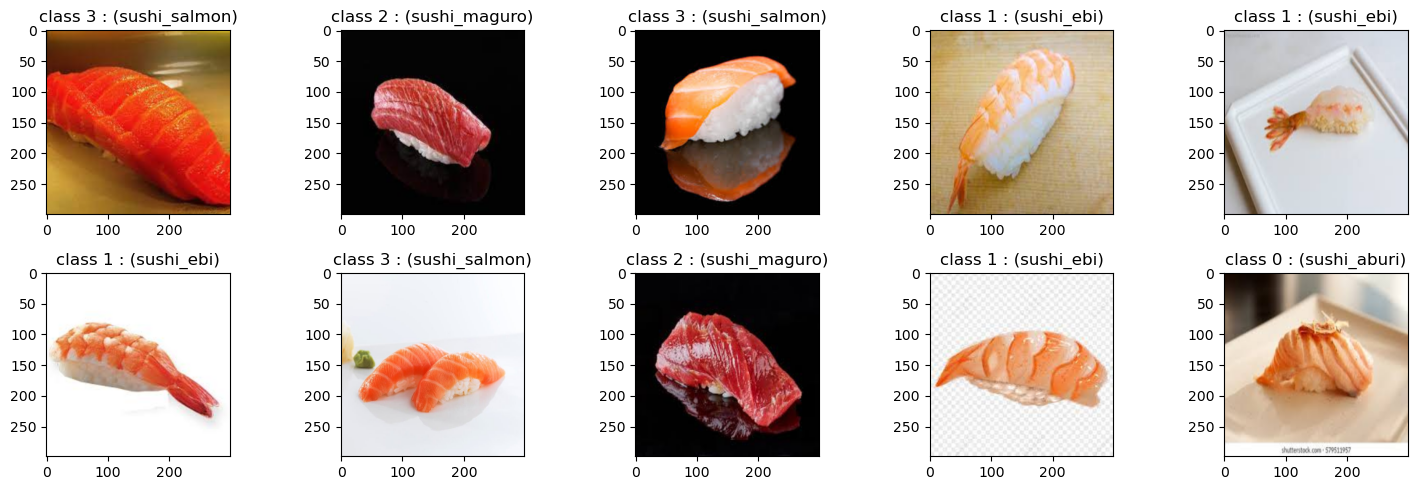

In [36]:
label = ['sushi_aburi','sushi_ebi','sushi_maguro','sushi_salmon']
plt.figure(figsize = (15,5))
for i in range(10):
  plt.subplot(2, 5, i+1).set_title(f'class {y_train[i]} : ({label[y_train[i]]})')
  plt.imshow(x_train[i])
  
plt.tight_layout() 
plt.show()

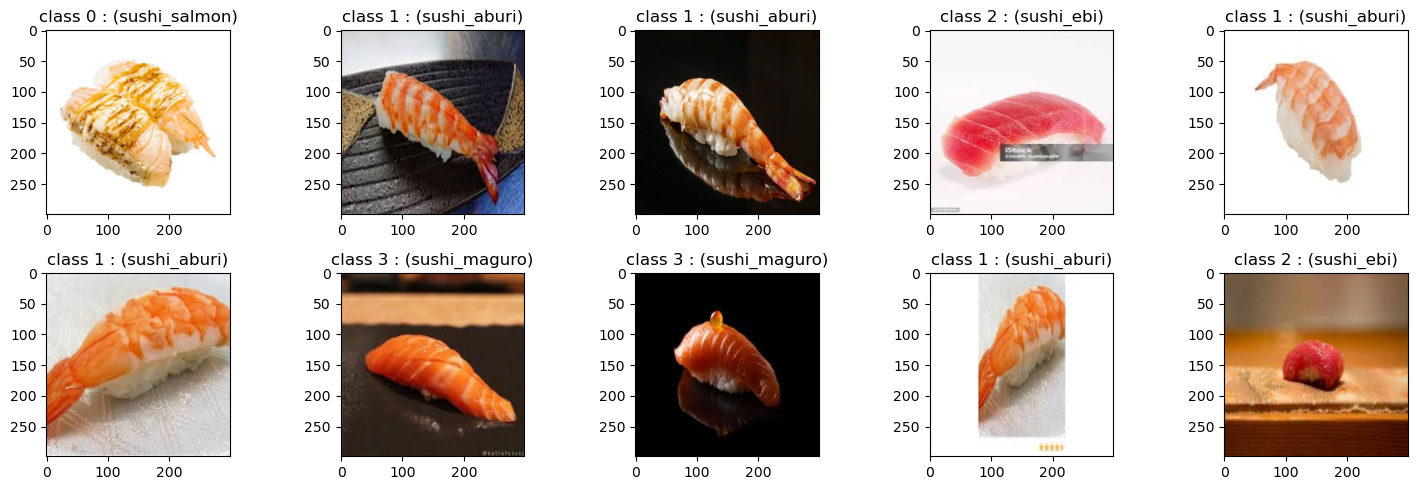

In [37]:
label = ['sushi_aburi','sushi_ebi','sushi_maguro','sushi_salmon']
plt.figure(figsize = (15,5))
for i in range(10):
  plt.subplot(2, 5, i+1).set_title(f'class {y_test[i]} : ({label[y_test[i]-1]})')
  plt.imshow(x_test[i])
  
plt.tight_layout()
plt.show()

# Select Pre-Trained Model Xception

In [38]:
x_extractor = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x_extractor.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

# Prepocessing

In [39]:
x_train_xception = tf.keras.applications.xception.preprocess_input(x_train)
x_test_xception = tf.keras.applications.xception.preprocess_input(x_test)

print(x_train_xception.shape)
print(x_test_xception.shape)

(550, 299, 299, 3)
(138, 299, 299, 3)


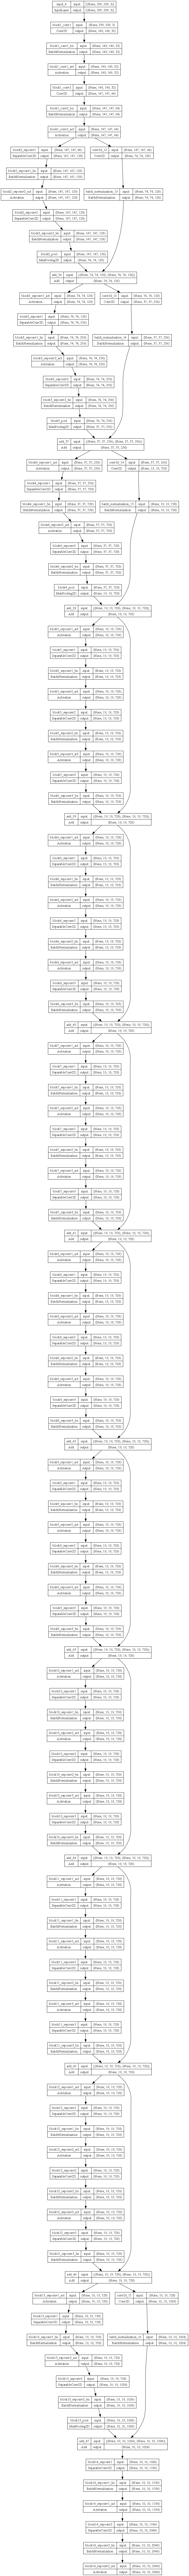

In [40]:
tf.keras.utils.plot_model(
    x_extractor, 
    to_file='./out/Xception_Model.png', 
    show_shapes=True, 
    show_dtype=False, 
    show_layer_names=True, 
    dpi=90,
    rankdir='TB', 
    expand_nested=True 
)

# Recursively freeze all layers in the model

In [42]:
x_extractor.trainable = False
for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_4, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv1_bn, Trainable = False
Layer 3: Name = block1_conv1_act, Trainable = False
Layer 4: Name = block1_conv2, Trainable = False
Layer 5: Name = block1_conv2_bn, Trainable = False
Layer 6: Name = block1_conv2_act, Trainable = False
Layer 7: Name = block2_sepconv1, Trainable = False
Layer 8: Name = block2_sepconv1_bn, Trainable = False
Layer 9: Name = block2_sepconv2_act, Trainable = False
Layer 10: Name = block2_sepconv2, Trainable = False
Layer 11: Name = block2_sepconv2_bn, Trainable = False
Layer 12: Name = conv2d_12, Trainable = False
Layer 13: Name = block2_pool, Trainable = False
Layer 14: Name = batch_normalization_13, Trainable = False
Layer 15: Name = add_36, Trainable = False
Layer 16: Name = block3_sepconv1_act, Trainable = False
Layer 17: Name = block3_sepconv1, Trainable = False
Layer 18: Name = block3_sepconv1_bn, Trainable = False
Layer 19: Name = block3_sepco

# Un-freez some layer

In [14]:
# #Access a layer by name
# a = x_extractor.get_layer('block5_conv3')
# #b = x_extractor.get_layer('block5_conv2')
# # c = x_extractor.get_layer('block5_conv1')
# # d = x_extractor.get_layer('block4_conv3')

# a.trainable=True
# #b.trainable=True
# # c.trainable=True
# # d.trainable=True

# #print(f'Layer {a}: Name = {a.name}, Trainable = {a.trainable}')

# for i, layer in enumerate(x_extractor.layers):
#   print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

# Data Augmentation

In [43]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rescale                       = 1./255,         # Normalize pixel values
    samplewise_center             = True,           # Mean-center each image independently
    samplewise_std_normalization  = True,           # Normalize each image by its own standard deviation
    rotation_range              = 30,               # Rotation range ± x degrees
    height_shift_range          = 5.0,              # Vertical shift range ±0.15
    width_shift_range           = 4.0,              # Horizontal shift range ±0.15
    shear_range                 = 2.0,              # Shear range
    zoom_range                  = 0.2,              # Zoom range
    horizontal_flip             = True,             # Horizontal flip
    vertical_flip               = True,             # Vertical flip
    #fill_mode                   ='nearest',        # Fill mode for new pixels
    validation_split            = 0.2              # Split for validation
    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rescale                       =1./255,
    samplewise_center             =True,
    samplewise_std_normalization  =True,
    )

# define seed to master seed
train_datagen.seed = seed_value
test_datagen.seed = seed_value

train_datagen.fit(x_train_xception)
test_datagen.fit(x_test_xception)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9804327..1.3697013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.269697..1.6472589].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4473855..3.8259666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2808638..5.5483465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6934372..1.8156148].


===== Train batch no. 1/1 =====


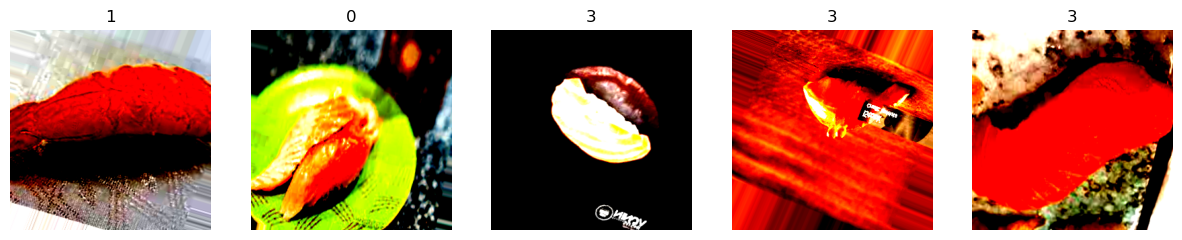

In [44]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=5, subset='training')
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(train_generator):
    print(f"===== Train batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7933947..1.7353442].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2172856..1.4315802].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2871786..1.2977884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6551652..1.6222358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6279583..3.0691602].


===== Validation batch no. 1/1 =====


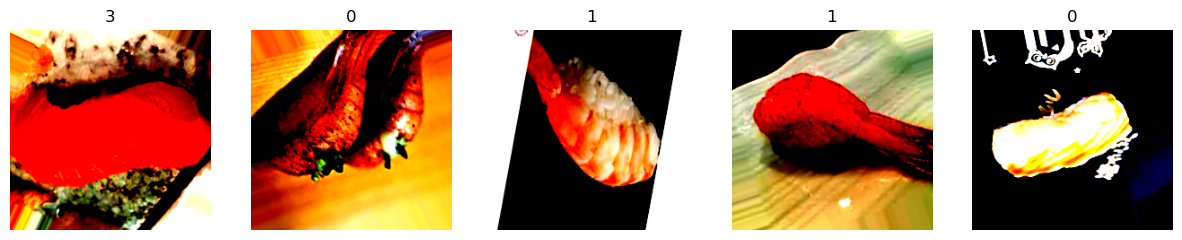

In [17]:
validation_generator = train_datagen.flow(x_train, y_train, batch_size=5, subset='validation')
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(validation_generator):
    print(f"===== Validation batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2744185..2.5788004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1633735..1.6625786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4879935..2.7811172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.569066..1.0021651].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.8673897..0.627055].


===== Test batch no. 1/1 =====


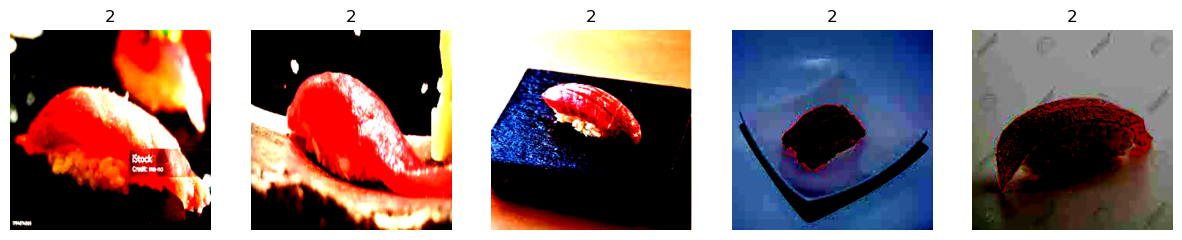

In [45]:
test_generator = test_datagen.flow(x_test, y_test, batch_size=5)
n_show = 1   # Show 'n_show' batches of generated data (1 batch includes 5 images)
for i, (x_batch, y_batch) in enumerate(test_generator):
    print(f"===== Test batch no. {i+1}/{n_show} =====")
    plt.figure(figsize=(15, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1).set_title(y_batch[j])
        plt.imshow(x_batch[j])
        plt.axis("off")  # remove all tick marks
    plt.show()

    if i+1 >= n_show:
        break

# Train Model

In [48]:
x = x_extractor.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
new_outputs = tf.keras.layers.Dense(4, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = x_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [50]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005) , 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['acc'] 
            )

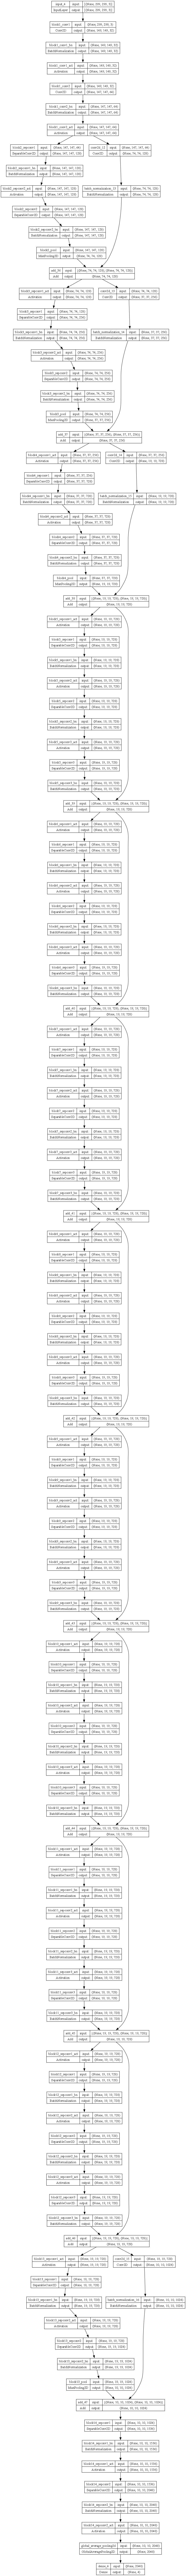

In [51]:
tf.keras.utils.plot_model(model, to_file = './out/Xception_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 90)

# Fitting Model

In [52]:
t_batch_size = 32
v_batch_size = 48

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # monitor 'val_loss', 'val_acc'
    patience=8,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation performance
)

# Fit the model with early stopping
history = model.fit(
    train_datagen.flow(x_train_xception, y_train, batch_size=t_batch_size, subset='training'),
    epochs=50,
    verbose=2,
    validation_data=train_datagen.flow(x_train_xception, y_train, batch_size=v_batch_size, subset='validation'),
    callbacks=[early_stopping]  # Include early stopping callback
)

Epoch 1/50
14/14 - 13s - loss: 1.3858 - acc: 0.2795 - val_loss: 1.3006 - val_acc: 0.4727 - 13s/epoch - 896ms/step
Epoch 2/50
14/14 - 7s - loss: 1.2442 - acc: 0.4977 - val_loss: 1.2147 - val_acc: 0.4909 - 7s/epoch - 498ms/step
Epoch 3/50
14/14 - 7s - loss: 1.1461 - acc: 0.5818 - val_loss: 1.1166 - val_acc: 0.6182 - 7s/epoch - 494ms/step
Epoch 4/50
14/14 - 7s - loss: 1.0610 - acc: 0.6500 - val_loss: 1.0580 - val_acc: 0.6455 - 7s/epoch - 490ms/step
Epoch 5/50
14/14 - 7s - loss: 0.9751 - acc: 0.7068 - val_loss: 0.9938 - val_acc: 0.6636 - 7s/epoch - 499ms/step
Epoch 6/50
14/14 - 7s - loss: 0.9235 - acc: 0.7136 - val_loss: 0.9719 - val_acc: 0.6909 - 7s/epoch - 488ms/step
Epoch 7/50
14/14 - 7s - loss: 0.8667 - acc: 0.7773 - val_loss: 0.9126 - val_acc: 0.7273 - 7s/epoch - 505ms/step
Epoch 8/50
14/14 - 7s - loss: 0.8382 - acc: 0.7523 - val_loss: 0.8918 - val_acc: 0.7000 - 7s/epoch - 495ms/step
Epoch 9/50
14/14 - 14s - loss: 0.8095 - acc: 0.7909 - val_loss: 0.8381 - val_acc: 0.7182 - 14s/epoch -

In [23]:
results = model.evaluate(test_datagen.flow(x_test_xception, y_test, batch_size = 64))
print(f'{model.metrics_names}: {results}')

3/3 [==============================] - 1s 109ms/step - loss: 0.9695 - acc: 0.5870
['loss', 'acc']: [0.9695072770118713, 0.5869565010070801]


# Save Model

In [24]:
# # save model
# model.save('./save/xception_base_model.h5')

# # save weight
# model.save_weights('./save/xception_base_weight.h5')

# Summarize history of accuracy

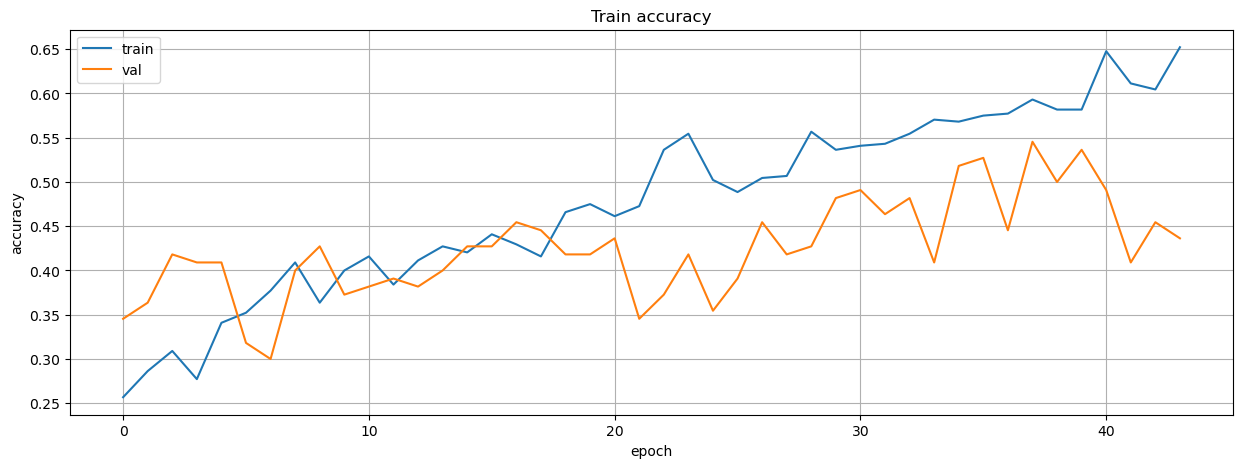

In [25]:
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

# Summarize history for loss

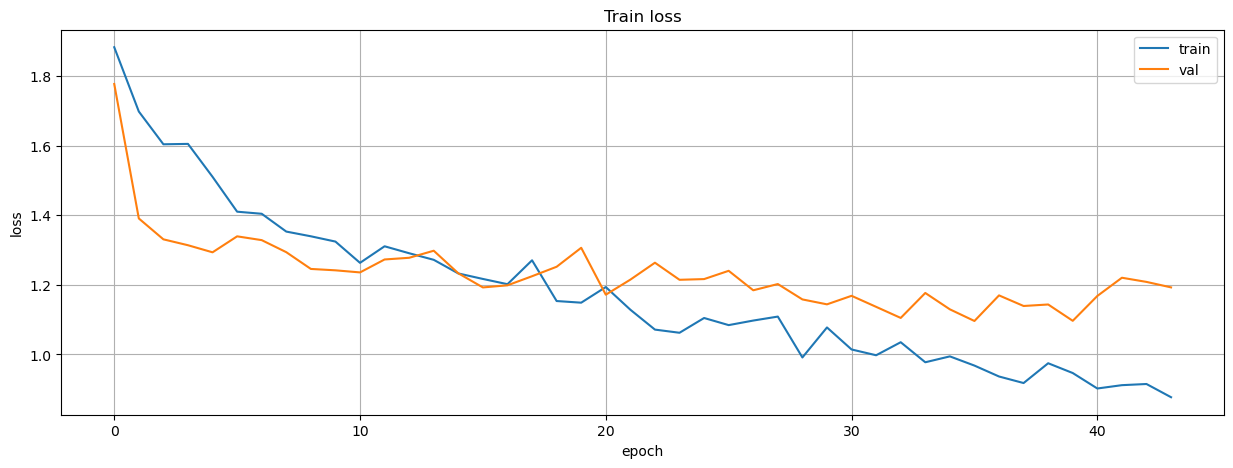

In [26]:
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

# Evaluate Model

1/1 [==============================] - 0s 16ms/step


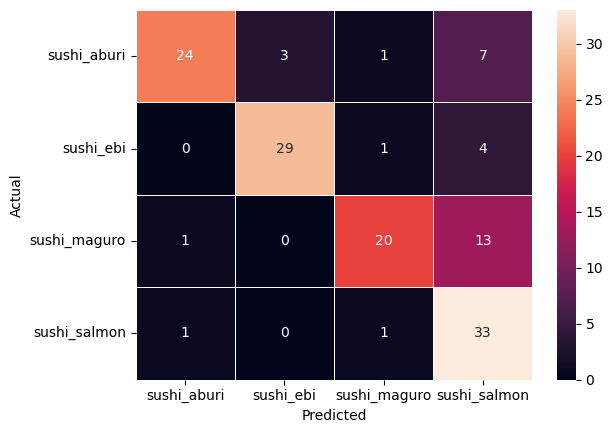

              precision    recall  f1-score   support

 sushi_aburi       0.92      0.69      0.79        35
   sushi_ebi       0.91      0.85      0.88        34
sushi_maguro       0.87      0.59      0.70        34
sushi_salmon       0.58      0.94      0.72        35

    accuracy                           0.77       138
   macro avg       0.82      0.77      0.77       138
weighted avg       0.82      0.77      0.77       138



In [53]:
# Get predictions for x_test_vgg16
y_pred = []
for i in range(len(x_test_xception)):
    x_input = x_test_xception[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=label)
print(report)

# Test Prediction

1/1 [==============================] - 0s 16ms/step


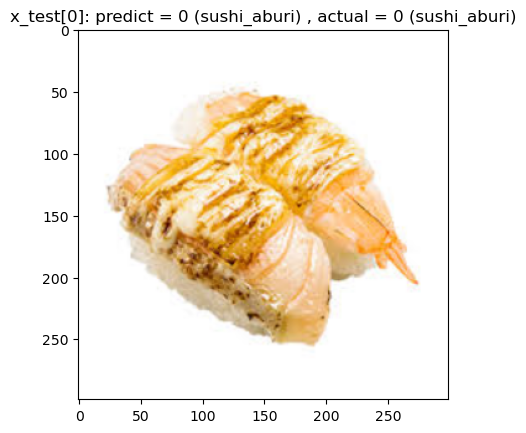

1/1 [==============================] - 0s 19ms/step


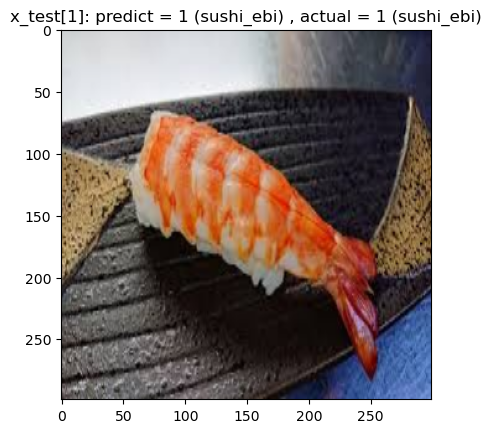

1/1 [==============================] - 0s 20ms/step


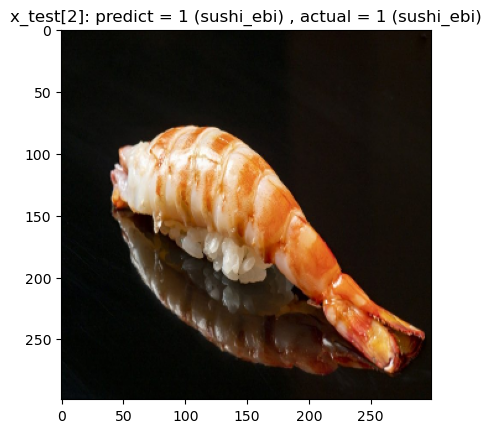

1/1 [==============================] - 0s 18ms/step


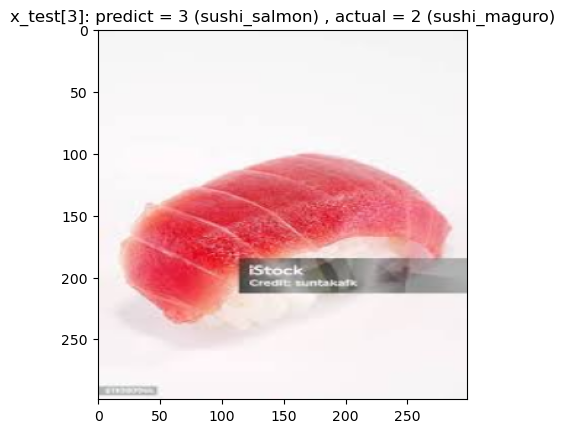

1/1 [==============================] - 0s 17ms/step


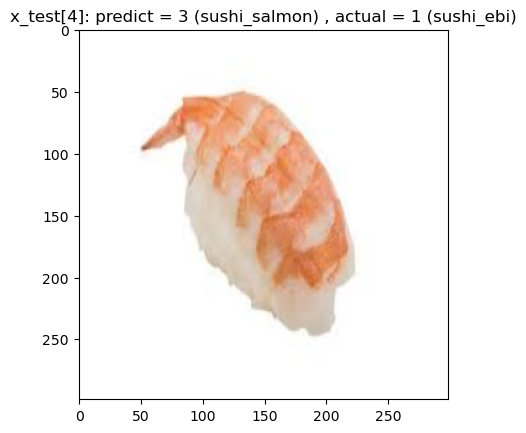

In [55]:
for i in range(5):
  y_pred = model.predict(x_test_xception[i].reshape(1,299,299,3))
  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()

# Grad-CAM

In [60]:
img_size = (299, 299)
preprocess_input = tf.keras.applications.xception.preprocess_input
last_conv_layer_name = "block14_sepconv2_act"

1/1 [==============================] - 0s 35ms/step
Predicted: sushi_aburi | Actual: sushi_aburi 


C:\Users\csorn\AppData\Local\Temp\ipykernel_15884\2585849484.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cmp.get_cmap("jet")


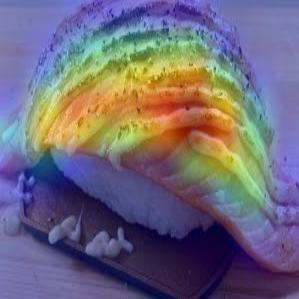

1/1 [==============================] - 0s 23ms/step
Predicted: sushi_maguro | Actual: sushi_maguro 


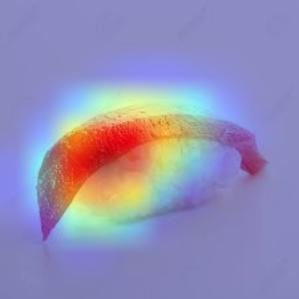

1/1 [==============================] - 0s 17ms/step
Predicted: sushi_maguro | Actual: sushi_maguro 


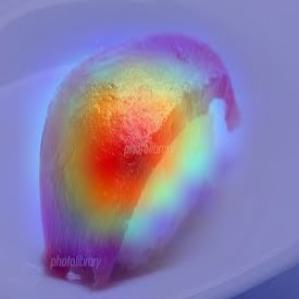

1/1 [==============================] - 0s 16ms/step
Predicted: sushi_salmon | Actual: sushi_ebi 


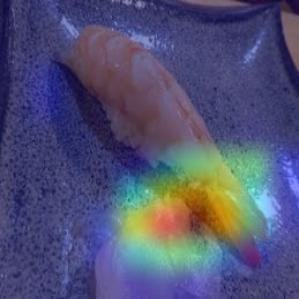

1/1 [==============================] - 0s 16ms/step
Predicted: sushi_salmon | Actual: sushi_ebi 


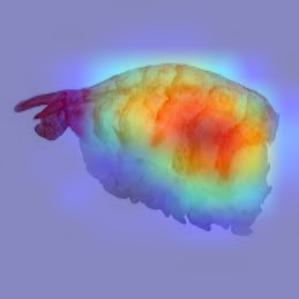

In [62]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="./out/cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c = np.random.randint(0,len(x_test)-1)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,299,299,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,299,299,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)